---
# 1. Paramètrage environnement et import des données

In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
plt.style.use("default")

from sklearn.model_selection import train_test_split

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, GlobalAveragePooling2D, Dropout
from keras.callbacks import EarlyStopping

from keras.applications import VGG16

In [2]:
def plot_result_fitting(history):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

    ax[0].plot(history.history['accuracy'], label='accuracy')
    ax[0].plot(history.history['val_accuracy'], label = 'val_accuracy')
    ax[0].set_title('Evolution de la précision')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    ax[1].plot(history.history['loss'], label='loss')
    ax[1].plot(history.history['val_loss'], label = 'val_loss')
    ax[1].set_title('Evolution de la fonction de perte')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    plt.savefig('./cnn_retention_map.png',
                transparent=True)
    
    return None

---
# 2. Préparation des données

Pour commencer, je récupère les données sous forme de dataframe afin de faciliter la découpe des fichier d'entraînement, de validation et de test.

In [3]:
dogs_lst = []
for dirname, _, filenames in os.walk('../input/stanford-dogs-dataset/images'):
    for filename in filenames:
        dogs_lst.append(os.path.join(dirname, filename))

# Je stocke dans un dataframe
dogs_raw = pd.DataFrame(dogs_lst, columns=['uri'])

# J'extrais la race
dogs_raw['breeds'] = dogs_raw.uri.str.split('/').str.get(5).str.slice(10)

dogs = dogs_raw

dogs

,uri,breeds
0,../input/stanford-dogs-dataset/images/Images/n...,Lakeland_terrier
1,../input/stanford-dogs-dataset/images/Images/n...,Lakeland_terrier
2,../input/stanford-dogs-dataset/images/Images/n...,Lakeland_terrier
3,../input/stanford-dogs-dataset/images/Images/n...,Lakeland_terrier
4,../input/stanford-dogs-dataset/images/Images/n...,Lakeland_terrier
...,...,...
20575,../input/stanford-dogs-dataset/images/Images/n...,miniature_poodle
20576,../input/stanford-dogs-dataset/images/Images/n...,miniature_poodle
20577,../input/stanford-dogs-dataset/images/Images/n...,miniature_poodle
20578,../input/stanford-dogs-dataset/images/Images/n...,miniature_poodle


In [4]:
# Séparation des données d'entrainements et de tests
train, test = train_test_split(dogs, test_size=0.2, random_state=42)

# Séparation des données d'entrainements et de validation
train, val = train_test_split(train, test_size=0.2, random_state=42)

In [5]:
### Paramétrage
target_size = (256, 256) # default
#target_size = (150, 150)
batch_size = 32 # default
# batch_size = 16

Data Augmentation

In [6]:
train_datagen = ImageDataGenerator(
                    rescale=1./255)

In [7]:
train_gen = train_datagen.flow_from_dataframe(
                  train,
                  x_col='uri',
                  y_col='breeds',
                  target_size=target_size,
                  batch_size=batch_size,
                  seed=42
                  )

# Génération des données de validation et de test
val_test_datagen = ImageDataGenerator(rescale=1./255)

val_gen = val_test_datagen.flow_from_dataframe(
                  val,
                  x_col='uri',
                  y_col='breeds',
                  target_size=target_size,
                  batch_size=batch_size,
                  seed=42
                  )

test_gen = val_test_datagen.flow_from_dataframe(
                  test,
                  x_col='uri',
                  y_col='breeds',
                  target_size=target_size,
                  batch_size=batch_size,
                  seed=42
                  )

Found 13171 validated image filenames belonging to 120 classes.
Found 3293 validated image filenames belonging to 120 classes.
Found 4116 validated image filenames belonging to 120 classes.


In [8]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
conv_base.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
______________________________________________________________

In [9]:
model = Sequential()

### Couches de convolutions
model.add(conv_base)
### Couches de Classification
# Applatissement (transform to vector 1D)
model.add(GlobalAveragePooling2D())
model.add(Dense(len(train_gen.class_indices), activation='softmax'))

# Résumé du modèle
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               61560     
Total params: 14,776,248
Trainable params: 14,776,248
Non-trainable params: 0
_________________________________________________________________


In [10]:
print('This is the number of trainable weights before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('This is the number of trainable weights after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 28
This is the number of trainable weights after freezing the conv base: 2


Epoch 1/500
412/412 [==============================] - 105s 255ms/step - loss: 4.6579 - accuracy: 0.0336 - val_loss: 4.5078 - val_accuracy: 0.0498
Epoch 2/500
412/412 [==============================] - 82s 198ms/step - loss: 4.3381 - accuracy: 0.0958 - val_loss: 4.2827 - val_accuracy: 0.1105
Epoch 3/500
412/412 [==============================] - 81s 198ms/step - loss: 4.1153 - accuracy: 0.1342 - val_loss: 4.1254 - val_accuracy: 0.1312
Epoch 4/500
412/412 [==============================] - 82s 200ms/step - loss: 3.9382 - accuracy: 0.1704 - val_loss: 3.9897 - val_accuracy: 0.1688
Epoch 5/500
412/412 [==============================] - 82s 199ms/step - loss: 3.7918 - accuracy: 0.1938 - val_loss: 3.8990 - val_accuracy: 0.1597
Epoch 6/500
412/412 [==============================] - 82s 199ms/step - loss: 3.6704 - accuracy: 0.2207 - val_loss: 3.8023 - val_accuracy: 0.1825
Epoch 7/500
412/412 [==============================] - 83s 200ms/step - loss: 3.5584 - accuracy: 0.2395 - val_loss: 3.7207 

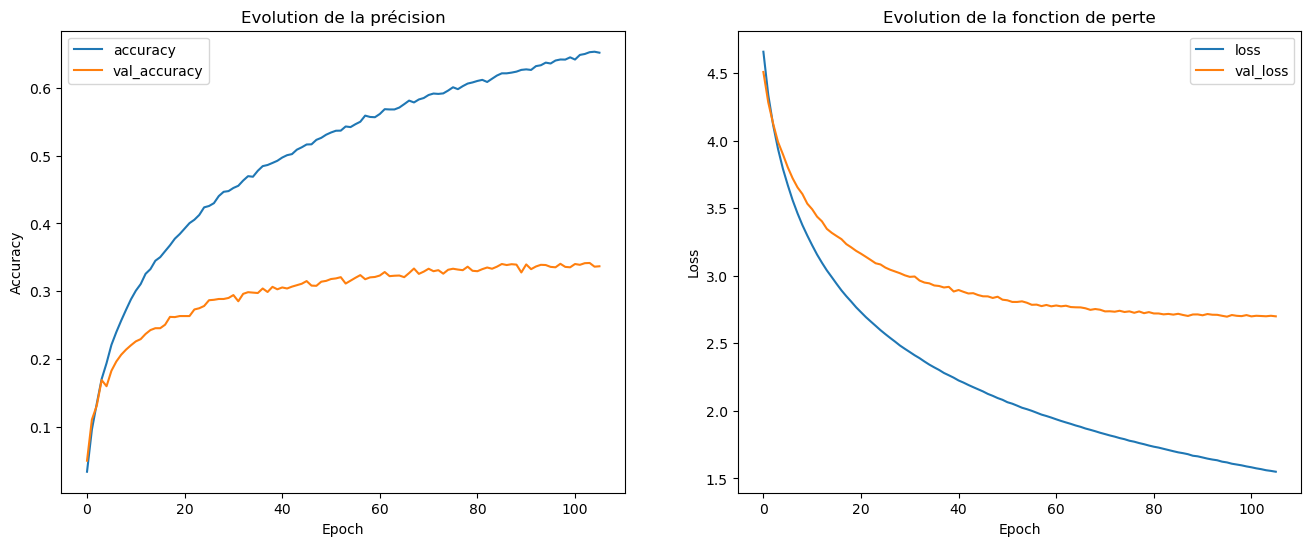

In [11]:
model.compile(optimizer='adam', # TO DO : essayer avec RMSprop
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping_monitor = EarlyStopping(patience=10)

history = model.fit(train_gen, validation_data=val_gen, epochs=500, callbacks = [early_stopping_monitor])

plot_result_fitting(history)

In [12]:
model.evaluate(test_gen)

129/129 [==============================] - 28s 220ms/step - loss: 2.6492 - accuracy: 0.3467


[2.649165391921997, 0.34669581055641174]